In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [15]:
start_day_to_analyze = '2020-06-02'
end_day_to_analyze = '2020-06-03'

In [16]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [17]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [18]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [19]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,3632,1275,AA,buy,447,9.99,"{'avg': 9.8426, 'rsi': 67.44373513525406, 'mac...",2020-06-02 14:31:06.623918+00:00,2020-06-02 14:31:07.312033,9.77,10.44
1,3625,1279,CASH,buy,355,19.13,"{'avg': 19.0177, 'rsi': 61.03067177532756, 'ma...",2020-06-02 14:26:03.132476+00:00,2020-06-02 14:26:04.405237,18.85,19.69
2,3633,1279,CASH,sell,355,18.78,"{'avg': 19.0165, 'rsi': [40.82571973356282, 35...",2020-06-02 15:07:33.773944+00:00,2020-06-02 15:07:34.395462,18.85,19.69
3,3621,1275,VSTO,buy,134,11.51,"{'avg': 11.202, 'rsi': 69.99431189597402, 'mac...",2020-06-02 14:04:53.635606+00:00,2020-06-02 14:04:54.691213,10.78,12.99
4,3622,1275,VSTO,sell,67,11.68,"{'avg': 11.283, 'rsi': [66.85551723041036, 69....",2020-06-02 14:22:25.285017+00:00,2020-06-02 14:22:25.758055,10.78,12.99
5,3623,1275,VSTO,sell,33,11.78,"{'avg': 11.3054, 'rsi': [67.94913041287471, 72...",2020-06-02 14:25:36.941982+00:00,2020-06-02 14:25:37.312062,10.78,12.99
6,3624,1275,VSTO,sell,17,11.88,"{'avg': 11.3124, 'rsi': [67.94913041287471, 74...",2020-06-02 14:25:57.172907+00:00,2020-06-02 14:25:57.610970,10.78,12.99
7,3626,1275,VSTO,sell,8,11.90,"{'avg': 11.3382, 'rsi': [76.05027881919348, 76...",2020-06-02 14:27:47.692365+00:00,2020-06-02 14:27:48.030266,10.78,12.99
8,3627,1275,VSTO,sell,4,11.92,"{'avg': 11.3438, 'rsi': [76.05027881919348, 77...",2020-06-02 14:27:52.555881+00:00,2020-06-02 14:27:52.886648,10.78,12.99
9,3628,1275,VSTO,sell,2,11.93,"{'avg': 11.3441, 'rsi': [76.05027881919348, 78...",2020-06-02 14:28:09.669217+00:00,2020-06-02 14:28:10.935438,10.78,12.99


In [20]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)
algo_runs.set_index('algo_run_id', inplace=True)

In [21]:
algo_runs

,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason,batch_id
algo_run_id,,,,,,,,
1275,momentum_long,PAPER,v0.1-472-g87afaa2,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-02 13:45:38.926145,2020-06-02 20:10:01.848644,market close,46038319-5e59-4a32-8240-bb4627ddc0f0
1276,momentum_long,PAPER,v0.1-472-g87afaa2,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-02 13:45:39.695635,NaT,None,46038319-5e59-4a32-8240-bb4627ddc0f0
1277,momentum_long,PAPER,v0.1-472-g87afaa2,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-02 13:45:40.811556,NaT,None,46038319-5e59-4a32-8240-bb4627ddc0f0
1278,momentum_long,PAPER,v0.1-472-g87afaa2,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-02 13:45:41.972259,NaT,None,46038319-5e59-4a32-8240-bb4627ddc0f0
1279,momentum_long,PAPER,v0.1-472-g87afaa2,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-02 13:45:42.949520,NaT,None,46038319-5e59-4a32-8240-bb4627ddc0f0


In [22]:
trade_details = {}
batch = {}
for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    batch_id = algo_runs.loc[algo_run_id]['batch_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))
    if batch_id not in batch:
        batch[batch_id] = []
    if algo_run_id not in batch[batch_id]:
        #print(batch_id, algo_run_id)
        batch[batch_id].append(algo_run_id)

In [23]:
revenues = {}
how_was_my_day = {}

for batch_id, count in batch.items():
    revenues[batch_id] = []
    symbol_name = []
    counts = []
    for run_id in batch[batch_id]:
        
        symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
        for symbol, count in symbols.items():
            revnue = 0
            for trade in trade_details[run_id][symbol]:
                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                revnue += delta

            revenues[batch_id].append(revnue)
            counts.append(count)
            symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[batch_id],
    }
    how_was_my_day[batch_id] = pd.DataFrame(data=d)

In [24]:
for batch_id, how_did_i_do in how_was_my_day.items():
    #display(HTML(algo_runs.loc[algo_runs['batch_id'] == batch_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[batch_id]).sum().round(2)} $ for {batch_id}')


,symbol,count,revenue
1,AA,1,-4465.53
2,CASH,2,-124.25
0,VSTO,10,33.37


TOTAL REVENUE: -4556.41 $ for 46038319-5e59-4a32-8240-bb4627ddc0f0


In [25]:
minute_history = {}
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
        for symbol, count in symbols.items():
            if symbol not in minute_history:
                minute_history[symbol] = api.polygon.historic_agg_v2(
                    symbol, 
                    1, 
                    'minute',
                    _from = str((datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date()),
                    to=str((datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date())).df


In [26]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4, minutes=1)
    #print(now)
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    #print(minute_history["close"][minute_history_index-10:minute_history_index])
    for back_track_min in range(120, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().between_time("9:30", "16:00").resample("5min").max()
        ).dropna()
        #print(series[-10:])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                #print([i for i in high_index if series[i] >= current_value])
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(120, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

VSTO analysis for run 1275 with profit 33.37


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1542.34,-1542.34,buy,2020-06-02 14:04:54.691213,11.51,"[10.87, 11.01, 11.08, 11.17, 11.17, 11.18, 11.18, 11.2]",[11.8499],134,"{'avg': 11.202, 'rsi': 69.99431189597402, 'macd': [0.06689758591216943, 0.07332366359675646, 0.07832046333713905, 0.08932000201308377, 0.09991941263368886], 'vwap': 11.4987, 'supports': [10.645, 10.66, 10.87, 11.17, 11.18], 'sell_macd': [0.036803408830243356, 0.04104506416997111, 0.044336677887033105, 0.05152057587581993, 0.058402566829734326], 'slow macd': [0.07115467231382233, 0.07326664923429327, 0.07525249181608729, 0.07855853492422149, 0.08207591639248157], 'macd_signal': [0.08032689805160693, 0.07892625116063684, 0.07880509359593728, 0.08090807527936658, 0.08471034275023104], 'resistances': [11.8499], 'position_ratio': '0.98', 'sell_macd_signal': [0.045868036360656096, 0.0449034419225191, 0.0447900891154219, 0.046136186467501505, 0.04858946253994807]}",12.99,10.78
1,-759.78,782.56,sell,2020-06-02 14:22:25.758055,11.68,None,None,67,"{'avg': 11.283, 'rsi': [66.85551723041036, 69.21348592146833], 'vwap': 11.68, 'reasons': 'scale-out', 'movement': 0.014769765421372713, 'sell_macd': [0.03694753889951308, 0.036816815257781244, 0.03701603300113554, 0.041106124320618775, 0.046097025032935335], 'sell_macd_signal': [0.046461524162374465, 0.04453258238145582, 0.043029272505391764, 0.042644642868437166, 0.0433351193013368]}",12.99,10.78
2,-371.04,388.74,sell,2020-06-02 14:25:37.312062,11.78,None,None,33,"{'avg': 11.3054, 'rsi': [67.94913041287471, 72.31410014331956], 'vwap': 11.7545, 'reasons': 'scale-out', 'movement': 0.007705479452054783, 'sell_macd': [0.041106124320618775, 0.046097025032935335, 0.048088674613532945, 0.05045504214888652, 0.056178769551125995], 'sell_macd_signal': [0.042644642868437166, 0.0433351193013368, 0.04428583036377603, 0.04551967272079813, 0.0476514920868637]}",12.99,10.78
3,-169.08,201.96,sell,2020-06-02 14:25:57.610970,11.88,None,None,17,"{'avg': 11.3124, 'rsi': [67.94913041287471, 74.31735809952417], 'vwap': 11.82, 'reasons': 'scale-out', 'movement': 0.0033955857385399766, 'sell_macd': [0.041106124320618775, 0.046097025032935335, 0.048088674613532945, 0.05045504214888652, 0.05877617214852826], 'sell_macd_signal': [0.042644642868437166, 0.0433351193013368, 0.04428583036377603, 0.04551967272079813, 0.048170972606344155]}",12.99,10.78
4,-73.88,95.20,sell,2020-06-02 14:27:48.030266,11.90,None,None,8,"{'avg': 11.3382, 'rsi': [76.05027881919348, 76.41933661134081], 'vwap': 11.8648, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.048088674613532945, 0.05045504214888652, 0.061373574745930526, 0.06908446281186187, 0.07471522672282305], 'sell_macd_signal': [0.04428583036377603, 0.04551967272079813, 0.04869045312582461, 0.05276925506303206, 0.057158449394990256]}",12.99,10.78
5,-26.20,47.68,sell,2020-06-02 14:27:52.886648,11.92,None,None,4,"{'avg': 11.3438, 'rsi': [76.05027881919348, 77.46128068158899], 'vwap': 11.8957, 'reasons': 'scale-out', 'movement': 0.0008403361344537636, 'sell_macd': [0.048088674613532945, 0.05045504214888652, 0.061373574745930526, 0.06908446281186187, 0.07627366828126547], 'sell_macd_signal': [0.04428583036377603, 0.04551967272079813, 0.04869045312582461, 0.05276925506303206, 0.05747013770667874]}",12.99,10.78
6,-2.34,23.86,sell,2020-06-02 14:28:10.935438,11.93,None,None,2,"{'avg': 11.3441, 'rsi': [76.05027881919348, 78.10621859352128], 'vwap': 11.9233, 'reasons': 'scale-out', 'movement': 0.0008389261744966264, 'sell_macd': [0.048088674613532945, 0.05045504214888652, 0.061373574745930526, 0.06908446281186187, 0.07731262932022531], 'sell_macd_signal': [0.04428583036377603, 0.04551967272079813, 0.04869045312582461, 0.05276925506303206, 0.05767792991447071]}",12.99,10.78
7,9.56,11.90,sell,2020-06-02 14:29:28.549793,11.90,None,None,1,"{'avg': 11.3697, 'rsi': [65.89364184828408, 69.21520750202109], 'vwap': 11.9, 'reasons': 'scale-out', 'movement': -0.002514668901927859,

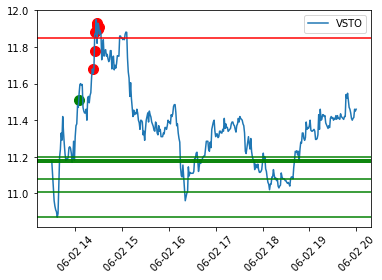

AA analysis for run 1275 with profit -4465.53


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4465.53,-4465.53,buy,2020-06-02 14:31:07.312033,9.99,[9.82],[10.39],447,"{'avg': 9.8426, 'rsi': 67.44373513525406, 'macd': [0.023994917967229412, 0.027291692017497482, 0.028550512803120043, 0.03080684803056677, 0.03240703263291955], 'vwap': 9.9926, 'supports': [9.4535, 9.69, 9.775, 9.82], 'sell_macd': [0.013334828709480107, 0.015520534366016747, 0.016362375989734446, 0.017844819125231837, 0.018887699242174705], 'slow macd': [0.04557051247965482, 0.04594389987222769, 0.04601082861705841, 0.04631868936371397, 0.04656463611325279], 'macd_signal': [0.022001863139844386, 0.023059828915375006, 0.024157965692924013, 0.025487742160452565, 0.026871600254945963], 'resistances': [10.335, 10.39, 10.53], 'position_ratio': '1.99', 'sell_macd_signal': [0.011755792911099242, 0.012508741202082743, 0.013279468159613084, 0.014192538352736834, 0.015131570530624408]}",10.44,9.77


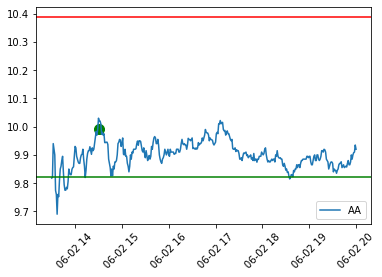

CASH analysis for run 1279 with profit -124.25


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6791.15,-6791.15,buy,2020-06-02 14:26:04.405237,19.13,"[18.42, 18.92, 19.0]",[19.27],355,"{'avg': 19.0177, 'rsi': 61.03067177532756, 'macd': [-0.008688674385826545, -0.0066653710931987575, -0.005004203315859712, 0.0019383549520348708, 0.009748754108340307], 'vwap': 19.1104, 'supports': [18.395, 18.53, 18.54, 18.54, 18.56, 18.92, 19.0], 'sell_macd': [-0.010463856190863652, -0.008780476696912842, -0.007354720251019131, -0.002511861718488717, 0.0028528574200876733], 'slow macd': [0.05349984801747354, 0.0524335309470807, 0.051368625028345605, 0.05142627276160283, 0.05187686946019454], 'macd_signal': [0.012203007132249907, 0.008429331487160175, 0.005742624526556198, 0.004981770611651932, 0.005935167310989607], 'resistances': [19.27], 'position_ratio': '1.08', 'sell_macd_signal': [0.0019965403230015016, -0.00015886308098136742, -0.0015980345149889201, -0.0017807999556888796, -0.0008540684805335689]}",19.69,18.85
1,-124.25,6666.90,sell,2020-06-02 15:07:34.395462,18.78,None,None,355,"{'avg': 19.0165, 'rsi': [40.82571973356282, 35.46680350859914], 'vwap': 18.84, 'reasons': 'stopped', 'movement': -0.01515943544171454, 'sell_macd': [-0.012559147643340651, -0.011602980042628275, -0.011746187366195926, -0.014042891938245816, -0.01902678002116076], 'sell_macd_signal': [-0.01904819133546454, -0.017559149076897287, -0.016396556734757015, -0.015925823775454775, -0.016546015024595972]}",19.69,18.85


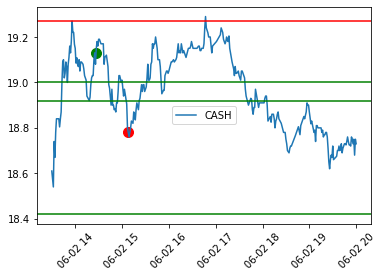

In [27]:
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        for symbol in minute_history:    
            if symbol not in trade_details[run_id]:
                continue
            start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
            minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
            plt.plot(minute_history[symbol]["close"][minute_history_index:].between_time("9:30", "16:00"), label=symbol)
            plt.xticks(rotation=45)
            delta = 0
            profit = 0

            operations = []
            deltas = []
            profits = []
            times = []
            prices = []
            qtys = []
            indicators = []
            target_price = []
            stop_price = []
            resistances = []
            supports = []
            for trade in trade_details[run_id][symbol]:
                resistance = None
                support = None
                if trade[0] == 'buy':
                    resistance = find_resistance(trade[2], minute_history[symbol], trade[1])

                    for r in resistance:
                        plt.axhline(y=r, color="r")
                    support = find_support(trade[2], minute_history[symbol], trade[1])
                    for s in support:
                        plt.axhline(y=s, color="g")  

                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                profit += delta
                plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
                deltas.append(round(delta, 2))
                profits.append(round(profit, 2))
                operations.append(trade[0])
                times.append(pd.to_datetime(trade[1]))
                prices.append(trade[2])
                qtys.append(trade[3])
                indicators.append(trade[4])
                target_price.append(trade[6])
                stop_price.append(trade[5])    
                resistances.append(resistance)
                supports.append(support)
            d = {
                'profit': profits,
                'trade': deltas,
                'operation': operations,
                'at': times,
                'price': prices,
                'support': supports,
                'resistance': resistances,
                'qty': qtys,
                'indicators': indicators,
                'target price': target_price,
                'stop price': stop_price
            }   
            print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
            display(HTML(pd.DataFrame(data=d).to_html()))
            plt.legend()
            plt.show()

In [ ]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))